## Calculate burst-glide statistics and lower-frequency speed changes for each fish in a trial

### Using speed data for each fish:
   - identify time windows without tracking errors/gaps
   - identify burst timing and features (max speed, peak-valley amplitude, rise time, fall time, potentially fit parameters)
   - get sliding burst rate and smoothed speed over time for analyzing speed crosscorrelation in lower frequencies
    

In [1]:
#import needed modules
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd  
from scipy.io import loadmat
import glob
import get_kinematics_adult as kin

In [2]:
# define directories and import list of lines
datadir = '../data/'
resultdir = 'savedresults/'

[treatments] = pickle.load(open(resultdir+'treatmentlist.pkl','rb'))
treatments = np.array(treatments)
numtreatments = len(treatments)
[focustreatments,notfocus] = pickle.load(open(resultdir+'focustreatmentlist.pkl','rb'))
[allnumtrials] = pickle.load(open(resultdir+'allnumtrials.pkl','rb'))

pxpercm = 4.02361434 * 10  # from tracker
dt=1/60

In [3]:
#import single line
tnum = 0  # select which line, 0 = WT
treatment = treatments[tnum]
numtrials = allnumtrials[tnum]
[trial_speeds,trial_trajectories,trial_headings,trial_theta,
            trial_smoothspeeds,trial_smoothtrajectories,trial_smoothheadings,
            trial_ellipses,trial_arena,trial_sex,
            datafiles,trial_trackingerrors] = pickle.load(open(datadir+treatment+'-alltrials.pkl','rb'))

In [4]:
#load fishpair distances from file
filename = datadir+treatment+'-dcoords+dist-heading.pkl'
[trial_dcoords,trial_dist] = pickle.load(open(filename,'rb'))

In [5]:
#select single trial for line and fish to include in analysis 
#define speed, position, & orientatino for current trial 
#(to do: set up to iterate through all trials & save relevant data)
trialnum = 8
fishIncl = np.arange(6) #maybe unecessary
nframes = trial_trajectories[trialnum].shape[0]
speeds = trial_speeds[trialnum].copy()
positions = trial_trajectories[trialnum].copy()
ori = trial_headings[trialnum].copy()

## Identify frames with bad data for each fish

In [6]:
#initialize badData dataframe; types: nan, flatspeed, doubleID (note which), other
errType = pd.DataFrame(np.zeros([nframes,fishIncl.size], dtype=int), columns = ['fish0','fish1','fish2','fish3','fish4','fish5'])
errType.index.name = 'frame'
errType.head()
errCode = {0: 'noError',
 1: 'missing',
 2: 'flatSpeed',
 30: 'doubleID_0',
 31: 'doubleID_1',
 32: 'doubleID_2',
 33: 'doubleID_3',
 34: 'doubleID_4',
 35: 'doubleID_5'}

In [7]:
#add nans/missing data to errType
errs = trial_trackingerrors[trialnum][:,fishIncl].copy()
errType[errs] = 1

In [8]:
#find flatspeed for each fish - speed does not change (or change < threshold); define as baddata
#currently doing for single frames, consider adding time threshold

accel = np.gradient(speeds,axis=0)
accel[1:] = speeds[1:]-speeds[0:-1]
accel[np.isnan(accel)] = 1.0 #set nans to real value > threshold
errs = (np.abs(accel)<0.001)
errType[errs] = 2

#to do: add time thresold for this, I think it's catching things it doesn't need to

In [9]:
#add additional nans (not included in trackingerrors, not sure why)
errs = np.isnan(speeds)
errType[errs] = 1 #may change to another code, but for now treating all gaps the same way

In [10]:
#define baddata for at least one fish in pair when [dist,oridiff] < threshold (doubleID error)

#for each fishpair, each time point, get distance (trial_dist from file) and orientation diff (subtr heading)
dthresh = pxpercm #1 cm, ~40 pixels; same threshold used in paper; I may use looser threshold
othresh = .2 #taken from paper

for i in fishIncl:
    col0 = errType.columns[i]
    errcode1 = 30 + i
    for j in range(i+1,fishIncl.size):
        col1 = errType.columns[j]
        errcode0 = 30 +j
        dpair = trial_dist[trialnum][:,i,j].copy() 
        dpair[np.isnan(dpair)] = 100 #set nans to high values to avoid invalid values and false errID
        oridiff = trial_headings[trialnum][:,i]-trial_headings[trialnum][:,j]
        oridiff[np.isnan(oridiff)] = 6 #set nans to high values to avoid invalid values and false errID
        indErr = (abs(oridiff) < othresh) & (dpair < dthresh)
        errType.loc[indErr,col0] = errcode0
        errType.loc[indErr,col1] = errcode1

## Restore speed and position for nans during bursts 
- These were filtered by acceleration filter in original data processing, which was needed to remove tracking "jumps"
- Filtering by gap duration and the speed change makes it possible to determine which of these are likely bursts and add the data back
- Note: I'm only doing this locally for now, not resaving the pickle; may consider running through for everything and then saving if (1) it takes a long time and (2) I'm comfortable that I've validated the process well

In [11]:
groupdatadir = datadir + 'raw/' 
datafiles = np.sort([str.split(s,'/')[-1] for s in glob.glob(groupdatadir+ treatment +'/*mat')])

#open datafile (one for now, set to iterate through after tests); get trajectories, speed, heading
data = loadmat(groupdatadir + datafiles[trialnum])
def loadval(dictval):
    return np.array([t[0][0] for t in (np.array(data['trx'][dictval]).T)]) 
data_x = loadval('x')
data_y = loadval('y')
trajectories_raw = np.array([data_x,data_y]).T
velocities = np.gradient(trajectories_raw,axis=0)/dt #if these are too slow, could do just for regions of interest
speeds_raw = np.sqrt(velocities[:,:,0]**2 + velocities[:,:,1]**2) 
headings_raw = np.arctan2(velocities[:,:,1],velocities[:,:,0]) 

#define thresholds for potential burst-gaps (time < some duration, speed change > some amount)
errchanges = errType.diff()
timeTH = 25 #preliminary guess for threshold
speedTH = 500 #preliminary guess for threshold - seems to catch most, and spot checks on smaller burst-gaps look like they have clear errors in the raw speeds (e.g. step changes)
errcode = 8

for fish in fishIncl:   
    #find regions of interest: criteria: NaN value, duration < fthresh, speedmax - speedmin > speedTH
    aux = (errType.iloc[:,[fish]] == 1) & (errchanges.iloc[:,[fish]] == 1)
    indstart = np.flatnonzero(aux.values)-1
    aux = (errType.iloc[:,[fish]] == 0) & (errchanges.iloc[:,[fish]] == -1)
    indend = np.flatnonzero(aux.values)
    #remove cases where indstart and indend do not line up
    aux = np.ones(indstart.size, dtype = bool)
    for i in range(indstart.size-1):
        if ~np.any((indend > indstart[i]) & (indend <= indstart[i+1])):
            aux[i] = False
    indstart = indstart[aux]
    indstart.size
    aux = np.ones(indend.size, dtype = bool)
    for i in range(1,indend.size):
        if ~np.any((indstart < indend[i]) & (indstart >= indend[i-1])):
            aux[i] = 0
    indend = indend[aux]
    if indstart[-1] > indend[-1]:
        indstart = indstart[:-1]
    if indstart[0] > indend[0]:
        indend = indend[1:]
    
    #filter for possible bursts
    gapdata = np.vstack([indend-indstart,speeds[indend,fish]-speeds[indstart,fish]]).T
    burstgap = np.where((gapdata[:,0] < timeTH) & (gapdata[:,1] > speedTH))[0] #possible excluded bursts
    
    #replace speed, trajectory, and heading with raw data for putative excluded bursts
    for gap in burstgap:
        errType.iloc[indstart[gap]:indend[gap],[fish]] = errcode #assign new errortype for timewindow, to keep track of (may remove later)
        positions[indstart[gap]:indend[gap],fish] = trajectories_raw[indstart[gap]:indend[gap],fish]  
        ori[indstart[gap]:indend[gap],fish] = headings_raw[indstart[gap]:indend[gap],fish]
        speeds[indstart[gap]:indend[gap],fish] = speeds_raw[indstart[gap]:indend[gap],fish] 

#??resave pickle? or new pickle? not doing currently, but may add later if this is too slow to repeat each time

Text(0.5, 1.0, 'ErrorType')

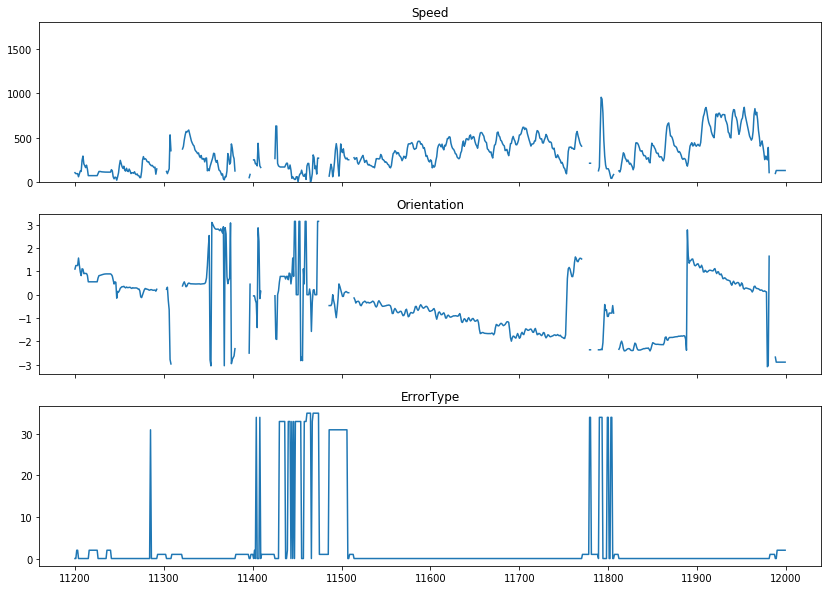

In [12]:
# plots to validate errtypes, burstgap fixes, overall data quality
fish = 0
minframe= 11200
duration = 800
maxframe = minframe + duration
xx = positions[minframe:maxframe,fish,0]
yy = positions[minframe:maxframe,fish,1]
# for orientations, best to use 'smoothheadings'
orientations = ori[minframe:maxframe,fish]
spd = speeds[minframe:maxframe,fish]
errs = errType.iloc[minframe:maxframe,[fish]]

# plot orientation and speed, and (opt) nan values
f,ax=plt.subplots(3,1,sharex=True)
f.set_size_inches(14,10)
a = ax[0]
a.plot(np.arange(minframe,maxframe),spd)
a.set_ylim([0,1800])
a.set_title('Speed')
a = ax[1]
a.plot(np.arange(minframe,maxframe),orientations)
a.set_title('Orientation')
a = ax[2]
a.plot(np.arange(minframe,maxframe),errs)
a.set_title('ErrorType')

# a = ax[6]
# a.plot(np.isnan(speeds))
# a.set_title('NaN values')
# plt.show()


## find bursts in speed trajectory

   - Build on get_kinematics function for getting BGCycle
   - Tweak parameters for burst detection (especially nback)
   - Maybe: try w both smoothed and raw trajectories, see which is better
   - Either only do for good trajectories, or note when burst is baddata

In [50]:
time = np.arange(nframes)*dt
bursts, burstrate = kin.getBGcycle(speeds[:,0], time = time, nbins = 5, threshold = 250.0, burstHtthresh = 100.0) 
bursts.set_index('n',inplace = True)

In [49]:
bursts.shape

(2214, 14)

In [22]:
#oriAligned = kin.getTurns(ori[fish],bursts,time) #needs to be adapted
#timeInactive = kin.getSwimTime(speed,time) #need to adapt for nans, maybe other

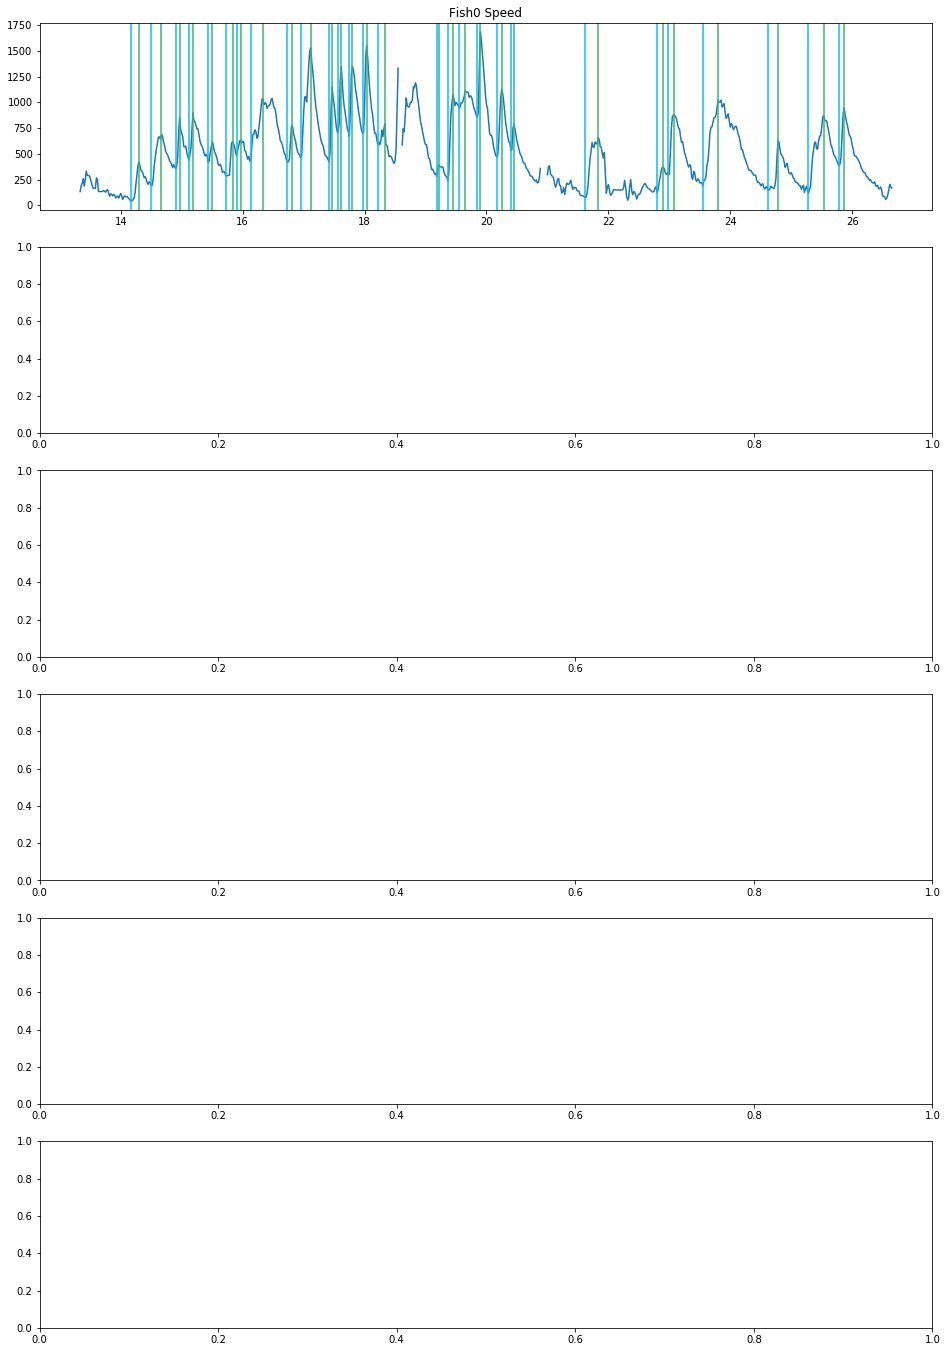

In [51]:
#plots to check burst detection

# for testing/debug
f0, axs = plt.subplots(6,1, figsize=(16,24))

twinsize = 800 #
twinstart = 800 
twinend = twinstart+twinsize
ind = np.arange(twinstart,twinsize+twinstart)

axs[0].plot(time[ind], speeds[ind,0])
axs[0].set_title('Fish0 Speed')

bstart = bursts.loc[(bursts['valleyTime'] > time[twinstart]) & (bursts['valleyTime'] < time[twinend]),['valleyTime']].values
bpeak = bursts.loc[(bursts['valleyTime'] > time[twinstart]) & (bursts['valleyTime'] < time[twinend]),['peakTime']].values
bb = np.hstack([bstart,bpeak])

#plot speed vs time or counter
for xc in bb:
    axs[0].axvline(x = xc[0],color='deepskyblue')
    axs[0].axvline(x = xc[1],color='mediumseagreen')


,valleyTime,peakTime,minSp,peakSp,burstHt,IBI,linfit_slope,linfit_int,quadrise_A,quadrise_B,expfit_A,expfit_C,expfit_D,failed_fit
n,,,,,,,,,,,,,,
0,0.316667,0.516667,296.905446,1775.196779,1.478291e+03,-1.000000,3056.721010,969.771696,-4090.831425,2170.374227,10650.412463,0.161449,-9164.686167,False
1,1.100000,1.166667,423.963745,979.301805,5.553381e+02,0.650000,10920.601507,1101.405451,136898.476082,22328.807853,NaN,NaN,NaN,True
2,2.850000,2.966667,18.064236,221.211162,2.031469e+02,1.800000,-1034.887644,4.982404,-19148.102330,-3587.967950,199.563711,52.031014,16.682718,False
3,3.583333,4.783333,13.243681,84.286591,7.104291e+01,1.816667,49.803422,62.136867,63.356741,126.887456,NaN,NaN,NaN,True
4,7.483333,7.533333,54.504636,54.504636,7.759127e-12,2.750000,-0.000005,54.504636,-0.000172,-0.000013,9361.856356,0.000424,-9306.591169,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3368,1797.316667,1797.483333,50.344676,216.327033,1.659824e+02,0.400000,720.300653,176.816871,-987.434846,539.270930,198.043549,11.293950,30.861775,False
3369,1797.750000,1797.866667,39.105166,135.175842,9.607068e+01,0.383333,538.247196,102.646506,4493.329921,1137.357852,54.304622,11.474485,78.245502,False
3370,1798.183333,1798.416667,60.515050,191.468165,1.309531e+02,0.550000,342.186855,135.891191,3492.493789,1215.310301,88.179282,1318.006145,103.288883,False


In [15]:
# maybe: kernel or wavelet smooth; don't want to do for now (I think burst coordination analysis may be better w/o it) but consider for later